one size: [0] cut= 3
one size: [1] cut= 3
one size: [1, 0] cut= 4
one size: [2] cut= 3
one size: [2, 0] cut= 4
one size: [2, 1] cut= 6
one size: [3] cut= 2
one size: [3, 0] cut= 5
one size: [3, 1] cut= 3
one size: [3, 2] cut= 5
one size: [4] cut= 3
one size: [4, 0] cut= 6
one size: [4, 1] cut= 6
one size: [4, 2] cut= 4
one size: [4, 3] cut= 5
one size: [5] cut= 4
one size: [5, 0] cut= 7
one size: [5, 1] cut= 5
one size: [5, 2] cut= 7
one size: [5, 3] cut= 6
one size: [5, 4] cut= 5
one size: [7] cut= 3
one size: [7, 0] cut= 6
one size: [7, 1] cut= 6
one size: [7, 2] cut= 6
one size: [7, 3] cut= 3
one size: [7, 4] cut= 4
one size: [7, 5] cut= 5
one size: [7, 6] cut= 6
one size: [6] cut= 3
one size: [6, 0] cut= 4
one size: [6, 1] cut= 6
one size: [6, 2] cut= 4
one size: [6, 3] cut= 5
one size: [6, 4] cut= 6
one size: [6, 5] cut= 5


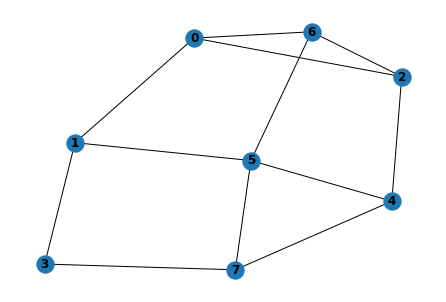

In [1]:
import networkx as nx
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
nx.draw(g, with_labels=True, font_weight='bold')

for i in g.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(g, [i]))            
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(g, [i, j])) 

In [4]:
from mindquantum import *
def build_hc(g, para):
    hc = Circuit()          
    for i in g.edges:
        hc += ZZ(para).on(i)        
    hc.barrier()                   
    return hc

# pylint: disable=W0104
circuit = build_hc(g, 'gamma')
circuit.svg()

def build_hb(g, para):
    hb = Circuit()          
    for i in g.nodes:
        hb += RX(para).on(i)     
    hb.barrier()             
    return hb

# pylint: disable=W0104
circuit = build_hb(g, 'beta')
circuit.svg()

# pylint: disable=W0104
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

def build_ansatz(g, p):                
    circ = Circuit()          
    for i in range(p):
        circ += build_hc(g, f'g{i}')     
        circ += build_hb(g, f'b{i}')    
    return circ

def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  
    return ham

# pylint: disable=W0104
p = 4
ham = Hamiltonian(build_ham(g))      
init_state_circ = UN(H, g.nodes)      
ansatz = build_ansatz(g, p)               
circ = init_state_circ + ansatz        
circ.svg()


In [9]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                    
grad_ops = sim.get_expectation_with_grad(ham, circ)            
net = MQAnsatzOnlyLayer(grad_ops)                       
opti = ms.nn.Adam(net.trainable_params(), learning_rate=0.05)   
train_net = ms.nn.TrainOneStepCell(net, opti)                    

for i in range(200):
    cut = (len(g.edges) - train_net()) / 2     
    if i%10 == 0:
        print("train step:", i, ", cut:", cut)  

pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) 
print(pr)

# pylint: disable=W0104
circ.measure_all()                               
sim.sampling(circ, pr=pr, shots=1000).svg()  

[WARNING] DEBUG(664,7f81432da740,python):2022-06-17-10:37:03.197.718 [mindspore/ccsrc/debug/debugger/debugger.cc:95] Debugger] Not enabling debugger. Debugger does not support CPU.
train step: 0 , cut: [6.000626]
train step: 10 , cut: [8.609472]
train step: 20 , cut: [9.1106825]
train step: 30 , cut: [9.406308]
train step: 40 , cut: [9.482845]
train step: 50 , cut: [9.536072]
train step: 60 , cut: [9.53565]
train step: 70 , cut: [9.543684]
train step: 80 , cut: [9.544094]
train step: 90 , cut: [9.544986]
train step: 100 , cut: [9.545125]
train step: 110 , cut: [9.545154]
train step: 120 , cut: [9.545203]
train step: 130 , cut: [9.545201]
train step: 140 , cut: [9.545206]
train step: 150 , cut: [9.545208]
train step: 160 , cut: [9.545208]
train step: 170 , cut: [9.545208]
train step: 180 , cut: [9.545208]
train step: 190 , cut: [9.545208]
{'g0': 0.17905912, 'b0': -1.1259358, 'g1': 0.3577799, 'b1': -0.8585863, 'g2': 0.4288344, 'b2': -0.6287034, 'g3': 0.48334113, 'b3': -0.3199273}
